In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image

# Path initialization
sys.path.insert(0, "../vae_architectures")
from VAE import VAE1
from CondVAE import CondVAE

from dataset import (ATTR_TO_IX_DICT, ATTR_IX_TO_KEEP, IX_TO_ATTR_DICT, N_ATTRS, 
                     FaceData_with_Attributes, tensor_to_attributes)

%matplotlib inline

In [49]:
def show(file_name, img, dpi=300, fontsize=10):
    npimg = img.numpy().transpose(1, 2, 0) 
    plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=fontsize)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)
    plt.show()

### Conditional VAE

In [52]:
model = CondVAE(hid_dim=128, KOF=32, p=0.04, N_ATTRS=N_ATTRS)
model.load_state_dict(torch.load("../train_vaes/weights/CondVAE_Liza_24_10_2019_02_04/weight.epoch_3_itr_94_loss_val_0.27323706766576256.pth"))
model = model.cuda()
model.eval()

CondVAE(
  (VAE): VAE1(
    (encoder): Sequential(
      (block01): Conv_block(
        (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block02): Conv_block(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block03): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block04): C

In [3]:
df_attr = pd.read_csv("../data/df_attr.csv")

img_names = {"train": df_attr.img_name.values[:55000], "val": df_attr.img_name.values[55000:]}
datasets = {phase: FaceData_with_Attributes(img_names[phase]) 
                for phase in ["train", "val"]}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=128, shuffle=True, num_workers=2) 
               for phase in ["train", "val"]}

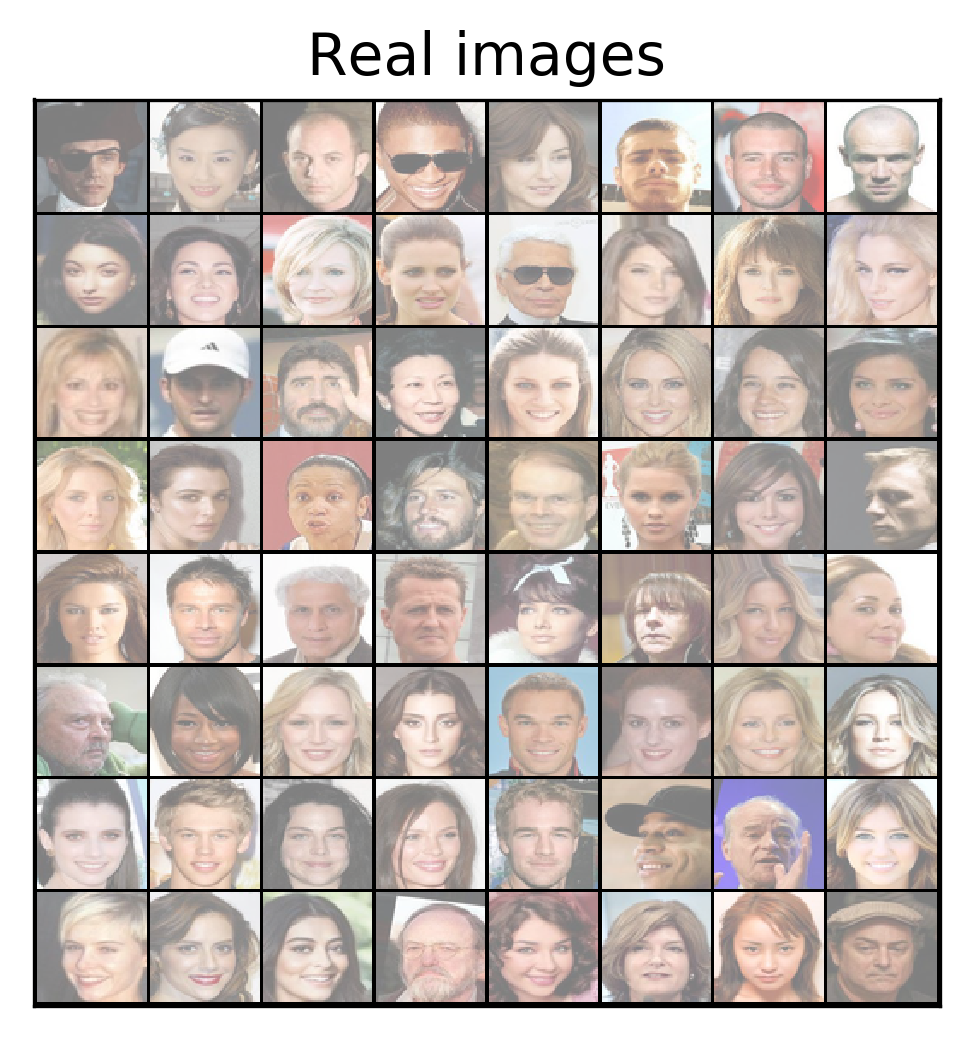

In [4]:
data, attr = next(iter(dataloaders["train"]))

show("Real images", make_grid((data[:64] * 0.5 + 0.5).cpu(), 8))

In [32]:
def generate_images_with_attrs(model, with_attr_list=[], no_attr_list=[], N=64, device=torch.device("cpu")):
    recon_images = []
    
    for i in range(N):
        attrs = torch.zeros(40)

        inds = np.arange(40)
        np.random.shuffle(inds)
        attrs[list(inds)[:10]] = 1
        
        for attr_name in with_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 1
            
        for attr_name in no_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 0

        attrs = attrs[ATTR_IX_TO_KEEP].cuda()

        recon_image, recon_attrs, mu, logvar = model(attrs=attrs[None], device=device)
        recon_image = torch.sigmoid(recon_image)
        recon_images.append(recon_image[0])
    
    recon_images = torch.stack(recon_images, dim=0)
    recon_images = recon_images.detach()
    return recon_images

#### Results

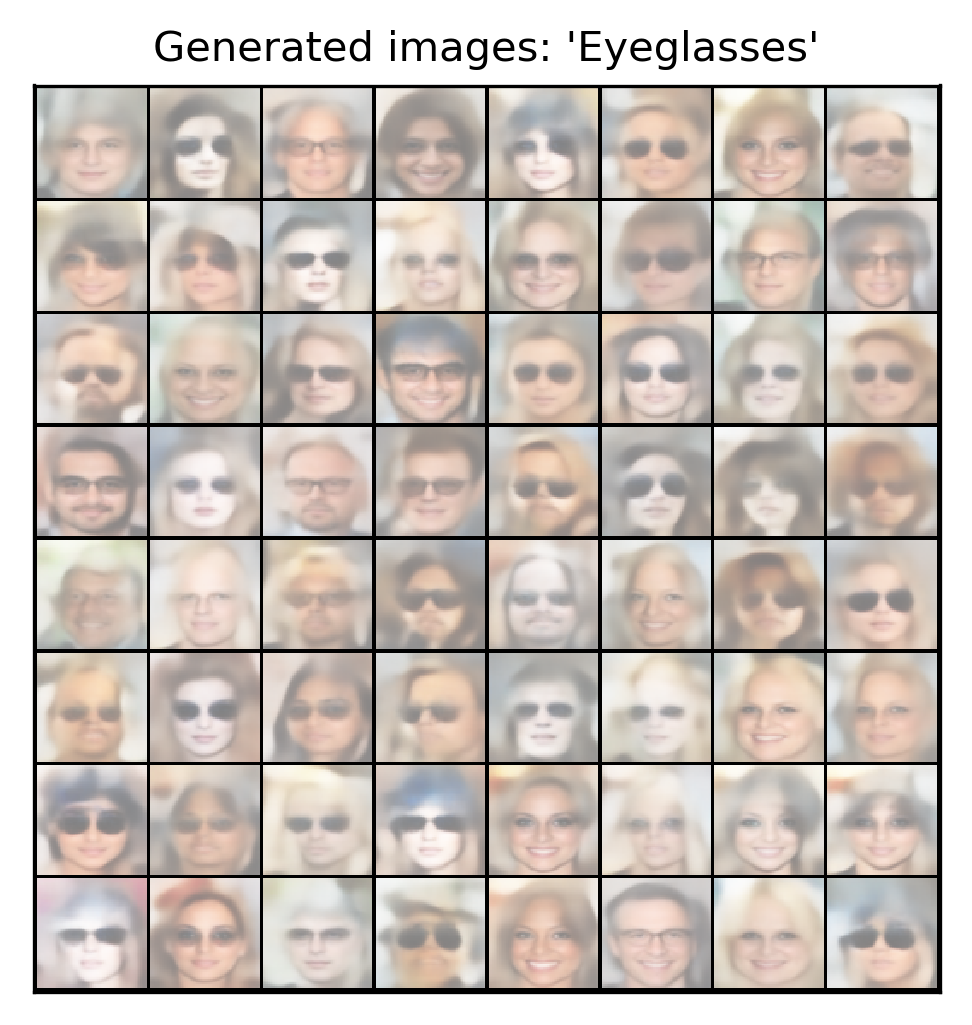

In [53]:
recon_images = generate_images_with_attrs(model, ["Eyeglasses"], N=64, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses'", make_grid((recon_images * 0.5 + 0.5).cpu(), 8))

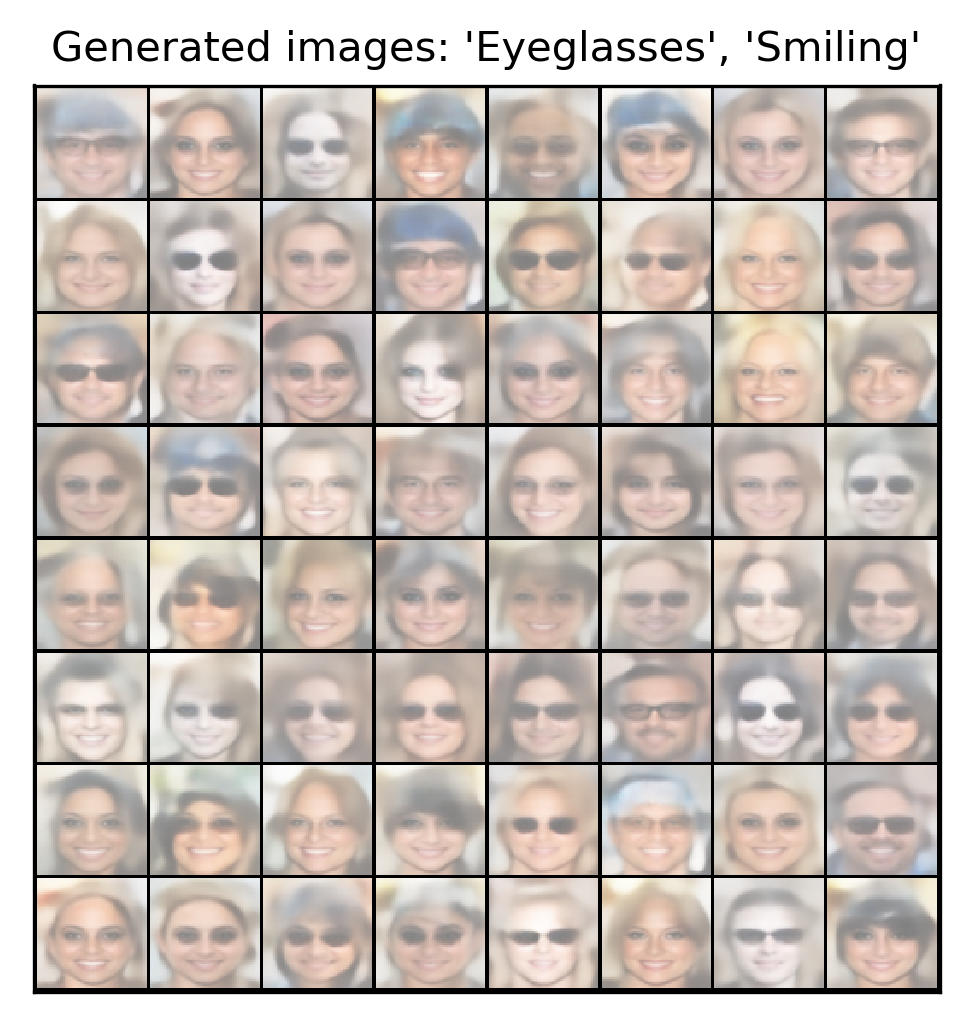

In [54]:
recon_images = generate_images_with_attrs(model, ['Eyeglasses', 'Smiling'], N=64, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses', 'Smiling'", make_grid((recon_images * 0.5 + 0.5).cpu(), 8))

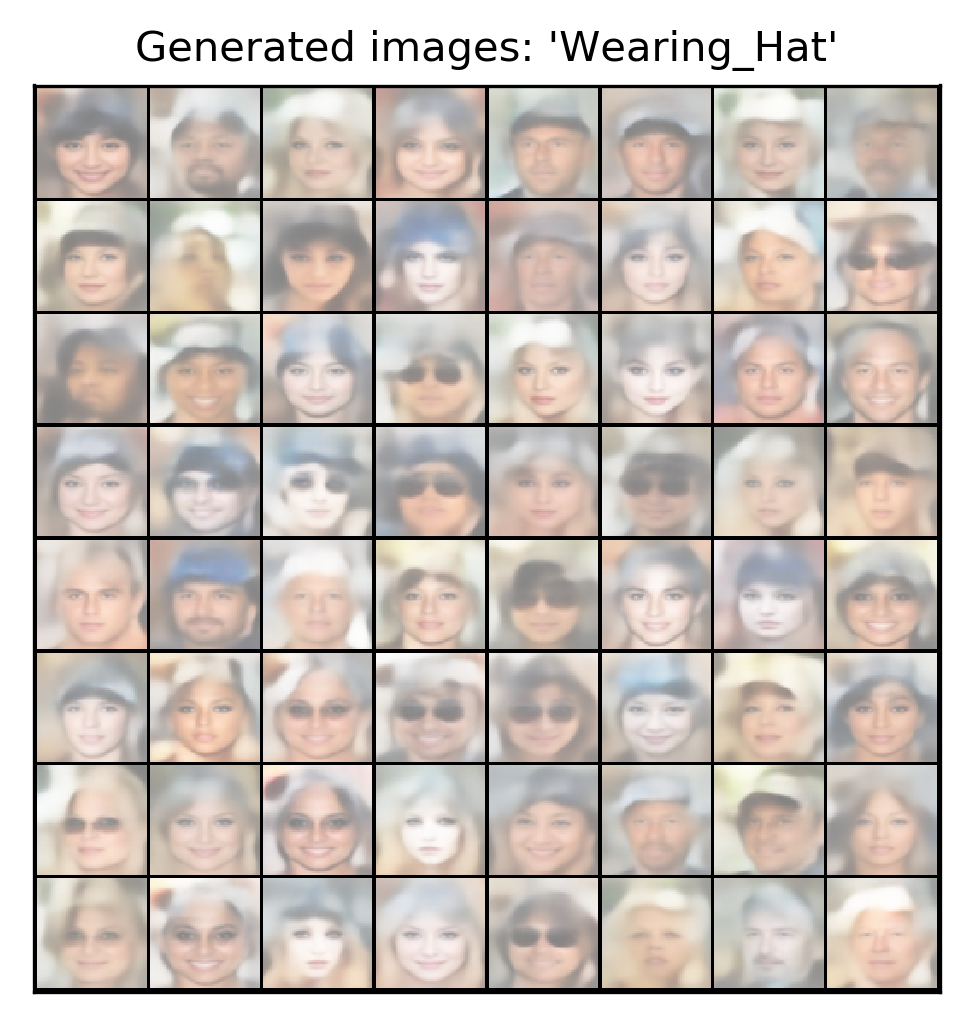

In [55]:
recon_images = generate_images_with_attrs(model, ['Wearing_Hat'], N=64, device=torch.device("cuda:0"))
show("Generated images: 'Wearing_Hat'", make_grid((recon_images * 0.5 + 0.5).cpu(), 8))

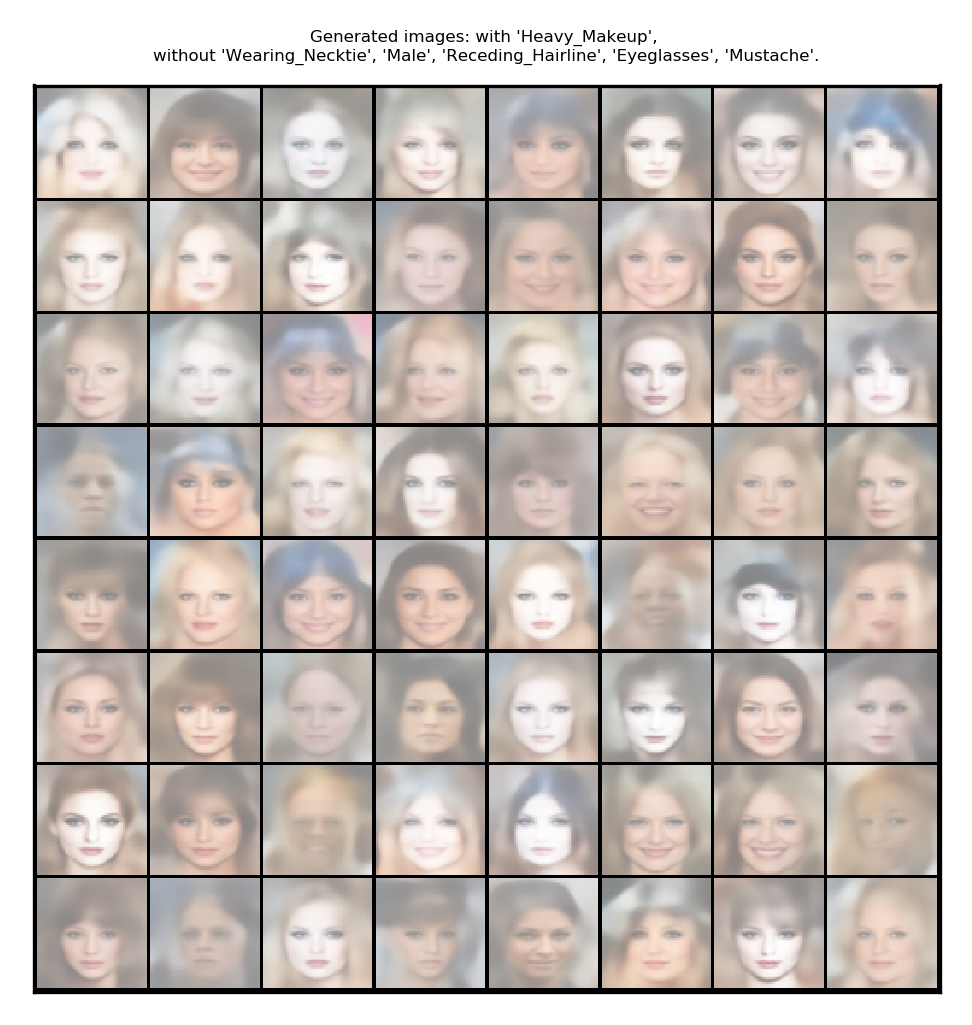

In [51]:
recon_images = generate_images_with_attrs(model, with_attr_list=['Heavy_Makeup'], 
                                          no_attr_list=["Wearing_Necktie", "Male", "Receding_Hairline",
                                                        "Mustache", "Eyeglasses"], 
                                          N=64, device=torch.device("cuda:0"))
show("Generated images: with 'Heavy_Makeup', " + 
     "\nwithout 'Wearing_Necktie', 'Male', 'Receding_Hairline', 'Eyeglasses', 'Mustache'.", 
     make_grid((recon_images * 0.5 + 0.5).cpu(), 8), fontsize=4)

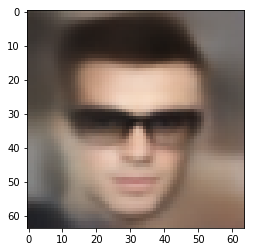

In [132]:
device = torch.device("cuda:0")

attrs = torch.zeros(40)

ind = np.arange(40)
np.random.shuffle(ind)
attrs[list(ind)[:10]] = 1
attrs[15] = 1

attrs = attrs[ATTR_IX_TO_KEEP].cuda()
attrs

recon_image_3, recon_attrs_3, mu_3, logvar_3 = model(attrs=attrs[None], device=device)
recon_image_3 = torch.sigmoid(recon_image_3)

plt.imshow(recon_image_3[0].detach().cpu().numpy().transpose(1, 2, 0))